# Building a Deep Convolutional Neural Network

## Introduction

In the previous chapter (cuadernos 004 a 005), we looked at a *traditional* deep **feedforward neural network**. One of the limitations of this *traditional* neural network is that it is not **translation-invariant**, that is, a cat image in the upper-right corner of an image would be considered different from an image that has a cat in the center of the image. Additionally, *traditional* neural networks are affected by the **scale** of an object. If the object is big in the majority of the images and a new image has the same object in it but with a smaller scale (occupies a smaller portion of the image), traditional neural networks are likely to fail in classifying the image. 

**Convolutional Neural Networks (CNNs)** are used to deal with such issues. Given that a CNN is able to deal with translation in images and also the scale of images, it is considered a lot more useful in object classification/detection. In this chapter, we will get into the following:

* Inaccuracy of traditional neural network when images are translated;
* Building a CNN from scratch using Python;
* Using CNNs to improve image classification on a MNIST dataset;
* Implementing data augmentation to improve network accuracy;
* Gender classification using CNNs.

## Inaccuracy of traditional neural networks when images are translated

Let's go through the following scenario: 

* Build a NN model to predict labels from the MNIST dataset;
* Consider all images that have a label of 1 and take an average of all of them (generating an *average 1 image*);
* Predict the label of the generated *average 1 image* using traditional NN; 
* Translate the *average 1 image* by $n$ pixels to the left or right;
* Make a prediction of the translated image using our traditional NN model.

### How to do it...

1. Download and extract the train and test MNIST dataset: 

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

2. Fetch the training set corresponding to label `1` only:

In [4]:
X_train1 = X_train[y_train==1]

3. Reshape and normalize the original dataset:

In [5]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0],num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0],num_pixels).astype('float32')
X_train = X_train / 255
X_test = X_test / 255

4. One-hot encode the output labels: 

In [6]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_train.shape[1]

5. Build, compile and fit a model:

In [7]:
model = Sequential()
model.add(Dense(1000, input_dim=num_pixels, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=5, batch_size=1024, verbose=1)

Epoch 1/5
59/59 [==============================] - 2s 27ms/step - loss: 0.8366 - accuracy: 0.7801 - val_loss: 0.2297 - val_accuracy: 0.9342
Epoch 2/5
59/59 [==============================] - 1s 16ms/step - loss: 0.2090 - accuracy: 0.9406 - val_loss: 0.1643 - val_accuracy: 0.9520
Epoch 3/5
59/59 [==============================] - 1s 17ms/step - loss: 0.1476 - accuracy: 0.9590 - val_loss: 0.1274 - val_accuracy: 0.9637
Epoch 4/5
59/59 [==============================] - 1s 17ms/step - loss: 0.1145 - accuracy: 0.9674 - val_loss: 0.1088 - val_accuracy: 0.9671
Epoch 5/5
59/59 [==============================] - 1s 17ms/step - loss: 0.0870 - accuracy: 0.9764 - val_loss: 0.0904 - val_accuracy: 0.9737


6. Generate and plot the *average 1 image* from the training set obtained in step 2. In the following code, we take an average pixel value at each pixel location of images that have a label of 1:

In [8]:
X_train1.shape

(6742, 28, 28)

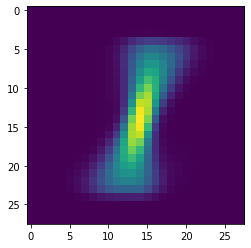

In [9]:
pic=np.zeros((28,28))
for i in range(X_train1.shape[0]):
    pic=pic+X_train1[i,:,:]
pic=(pic/X_train1.shape[0])
plt.imshow(pic);

Note that the more yellow the pixel is, the more often people have written on top of the pixel, and the less yellow (more blue) the pixel, the less often people have written on top of the pixel. Also, note that the pixel in the middle is the yellowest! (i.e. most people would be writing over the middle pixels.

7. Predict the label of the image using the built model. Firstly, we use the `predict` method to calculate the expected output:

In [10]:
X_avg = pic.reshape(1,num_pixels)/255

In [11]:
pred = model.predict(X_avg)
print(np.shape(pred))
print(pred)

(1, 10)
[[5.3360061e-05 9.6113276e-01 1.7452780e-03 2.9902654e-03 2.8800243e-04
  7.0115342e-04 3.3435054e-04 1.1328172e-03 3.0962024e-02 6.6001288e-04]]


Lastly, we obtain the index that has the highest probability value:

In [12]:
val = np.argmax(pred)
print(val)
print(pred[0,val])

1
0.96113276


### Scenario 1

Let's create a new image where the original image is translated by 1
pixel toward the left. In the following code, we loop through the columns of the image and copy the pixel values of the next column to the current column:

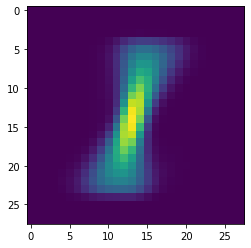

In [13]:
pic1=np.zeros((28,28))
for i in range(pic.shape[0]-1):
    pic1[:,i]=pic[:,i+1]
plt.imshow(pic1);

Predict the label of the new image using the built model:

In [14]:
X_avg1 = pic1.reshape(1,num_pixels)/255
pred1 = model.predict(X_avg1)
val1 = np.argmax(pred1)
print(val1)
print(pred1[0,val1])

1
0.6800499


We obtain a prediction of 1, albeit with a **lower probability** value as compared to the case without translation.

### Scenario 2

A new image is created in which the pixels of the original image are shifted by 2 pixels to the right:

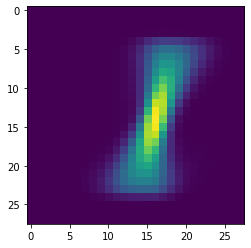

In [15]:
pic2=np.zeros((28,28))
for i in np.arange(2,pic.shape[0]):
    pic2[:,i]=pic[:,i-2]
plt.imshow(pic2);

Predict the label of the new image using the built model:

In [16]:
X_avg2 = pic2.reshape(1,num_pixels)/255
pred2 = model.predict(X_avg2)
val2 = np.argmax(pred2)
print(val2)
print(pred2[0,val2])

3
0.3863075


We see that the prediction is **incorrect** with an output of 3. This is the problem that we will be addressing by using a CNN !!! 